---
# Normality, Homoscedasticity (equality of variance)

In [5]:
import pingouin as pg

all_96 = pd.concat([all_96_cs, all_96_bm, all_96_hs])
display(pg.homoscedasticity(all_96, dv='total_unique_hits', group='hs_id'))

,W,pval,equal_var
levene,2.053994,0.000016,False


In [6]:
import rpy2
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
import rpy2.robjects.packages as rpackages
from rpy2.robjects.packages import importr, data
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

install_packages = False
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
utils.install_packages('rlang')
if install_packages:
    utils = rpackages.importr('utils')
    utils.chooseCRANmirror(ind=1)
    packnames = ('scmamp', 'BiocManager', 'rlang')

    names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
    if len(names_to_install) > 0:
        utils.install_packages(StrVector(names_to_install))
        
    biocmanager = rpackages.importr('BiocManager')
    biocmanager.install('Rgraphviz')
    biocmanager.install('graph')
    
scmamp = rpackages.importr('scmamp')

R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/3.6/rlang_0.4.7.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 1149552 bytes (1.1 MB)

R[write to console]: downloaded 1.1 MB




package 'rlang' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Moeman\AppData\Local\Temp\Rtmp0s1rEs\downloaded_packages


In [52]:
from stat_analysis import *

top_96_hs = get_top_summary(all_96_hs)
top_96_bm = get_top_summary(all_96_bm)
top_96_cs = get_top_summary(all_96_cs)
top_96_all = pd.concat([top_96_cs, top_96_bm, top_96_hs])

metric = 'total_hits'
topk = 47
sorted_hs_ids = top_96_all.sort_values('{}_mean'.format(metric), ascending=False).index.tolist()

all_96 = pd.concat([all_96_cs, all_96_bm, all_96_hs])
all_96 = all_96[all_96['hs_id'].isin(sorted_hs_ids[:topk])]

hs_ids = sorted_hs_ids[:topk]
rf_ids = all_96['rf_id'].unique()

data_df = pd.DataFrame(data=np.zeros(shape=(len(rf_ids),len(hs_ids))),
                  columns=hs_ids, index=rf_ids)
metric = 'total_hits'
for hs_id in hs_ids:
    for rf_id in rf_ids:
        tmp_df = all_96[(all_96['hs_id'] == hs_id) & (all_96['rf_id'] == rf_id)]
        
        # for (strategy, rf_id) that don't exist, we set it to mean of strategy runs that do exist
        if tmp_df.shape[0] > 0:
            metric_val = tmp_df[metric].iloc[0]
        else: 
            metric_val = all_96[all_96['hs_id'] == hs_id][metric].mean()
        
        data_df.loc[rf_id, hs_id] = metric_val


data_df.index = [x.replace('ClusterBasedWCSelector', 'CBWS') for x in data_df.index]
data_df.columns = [x.replace('ClusterBasedWCSelector', 'CBWS') for x in data_df.columns]

res = scmamp.imanDavenportTest(data_df)
corr_friedman_chisq = res[0][0]
df1, df2 = res[1]
pval = res[2][0]
print(corr_friedman_chisq, df1, df2, pval)

# perform nemenyi test
res = scmamp.nemenyiTest(data_df, alpha=0.1)
crit_diff = res[0][0]
k, df = res[1]
nem_diff_mat = res[4]
nem_diff_df = pd.DataFrame(nem_diff_mat, columns=data_df.columns, index=data_df.columns)

# Any two algorithms whose performance difference > than the critical difference are regarded as significantly different.
sig_diff_df = nem_diff_df.abs() > crit_diff

5.078601545838844 46.0 414.0 0.0


<AxesSubplot:>

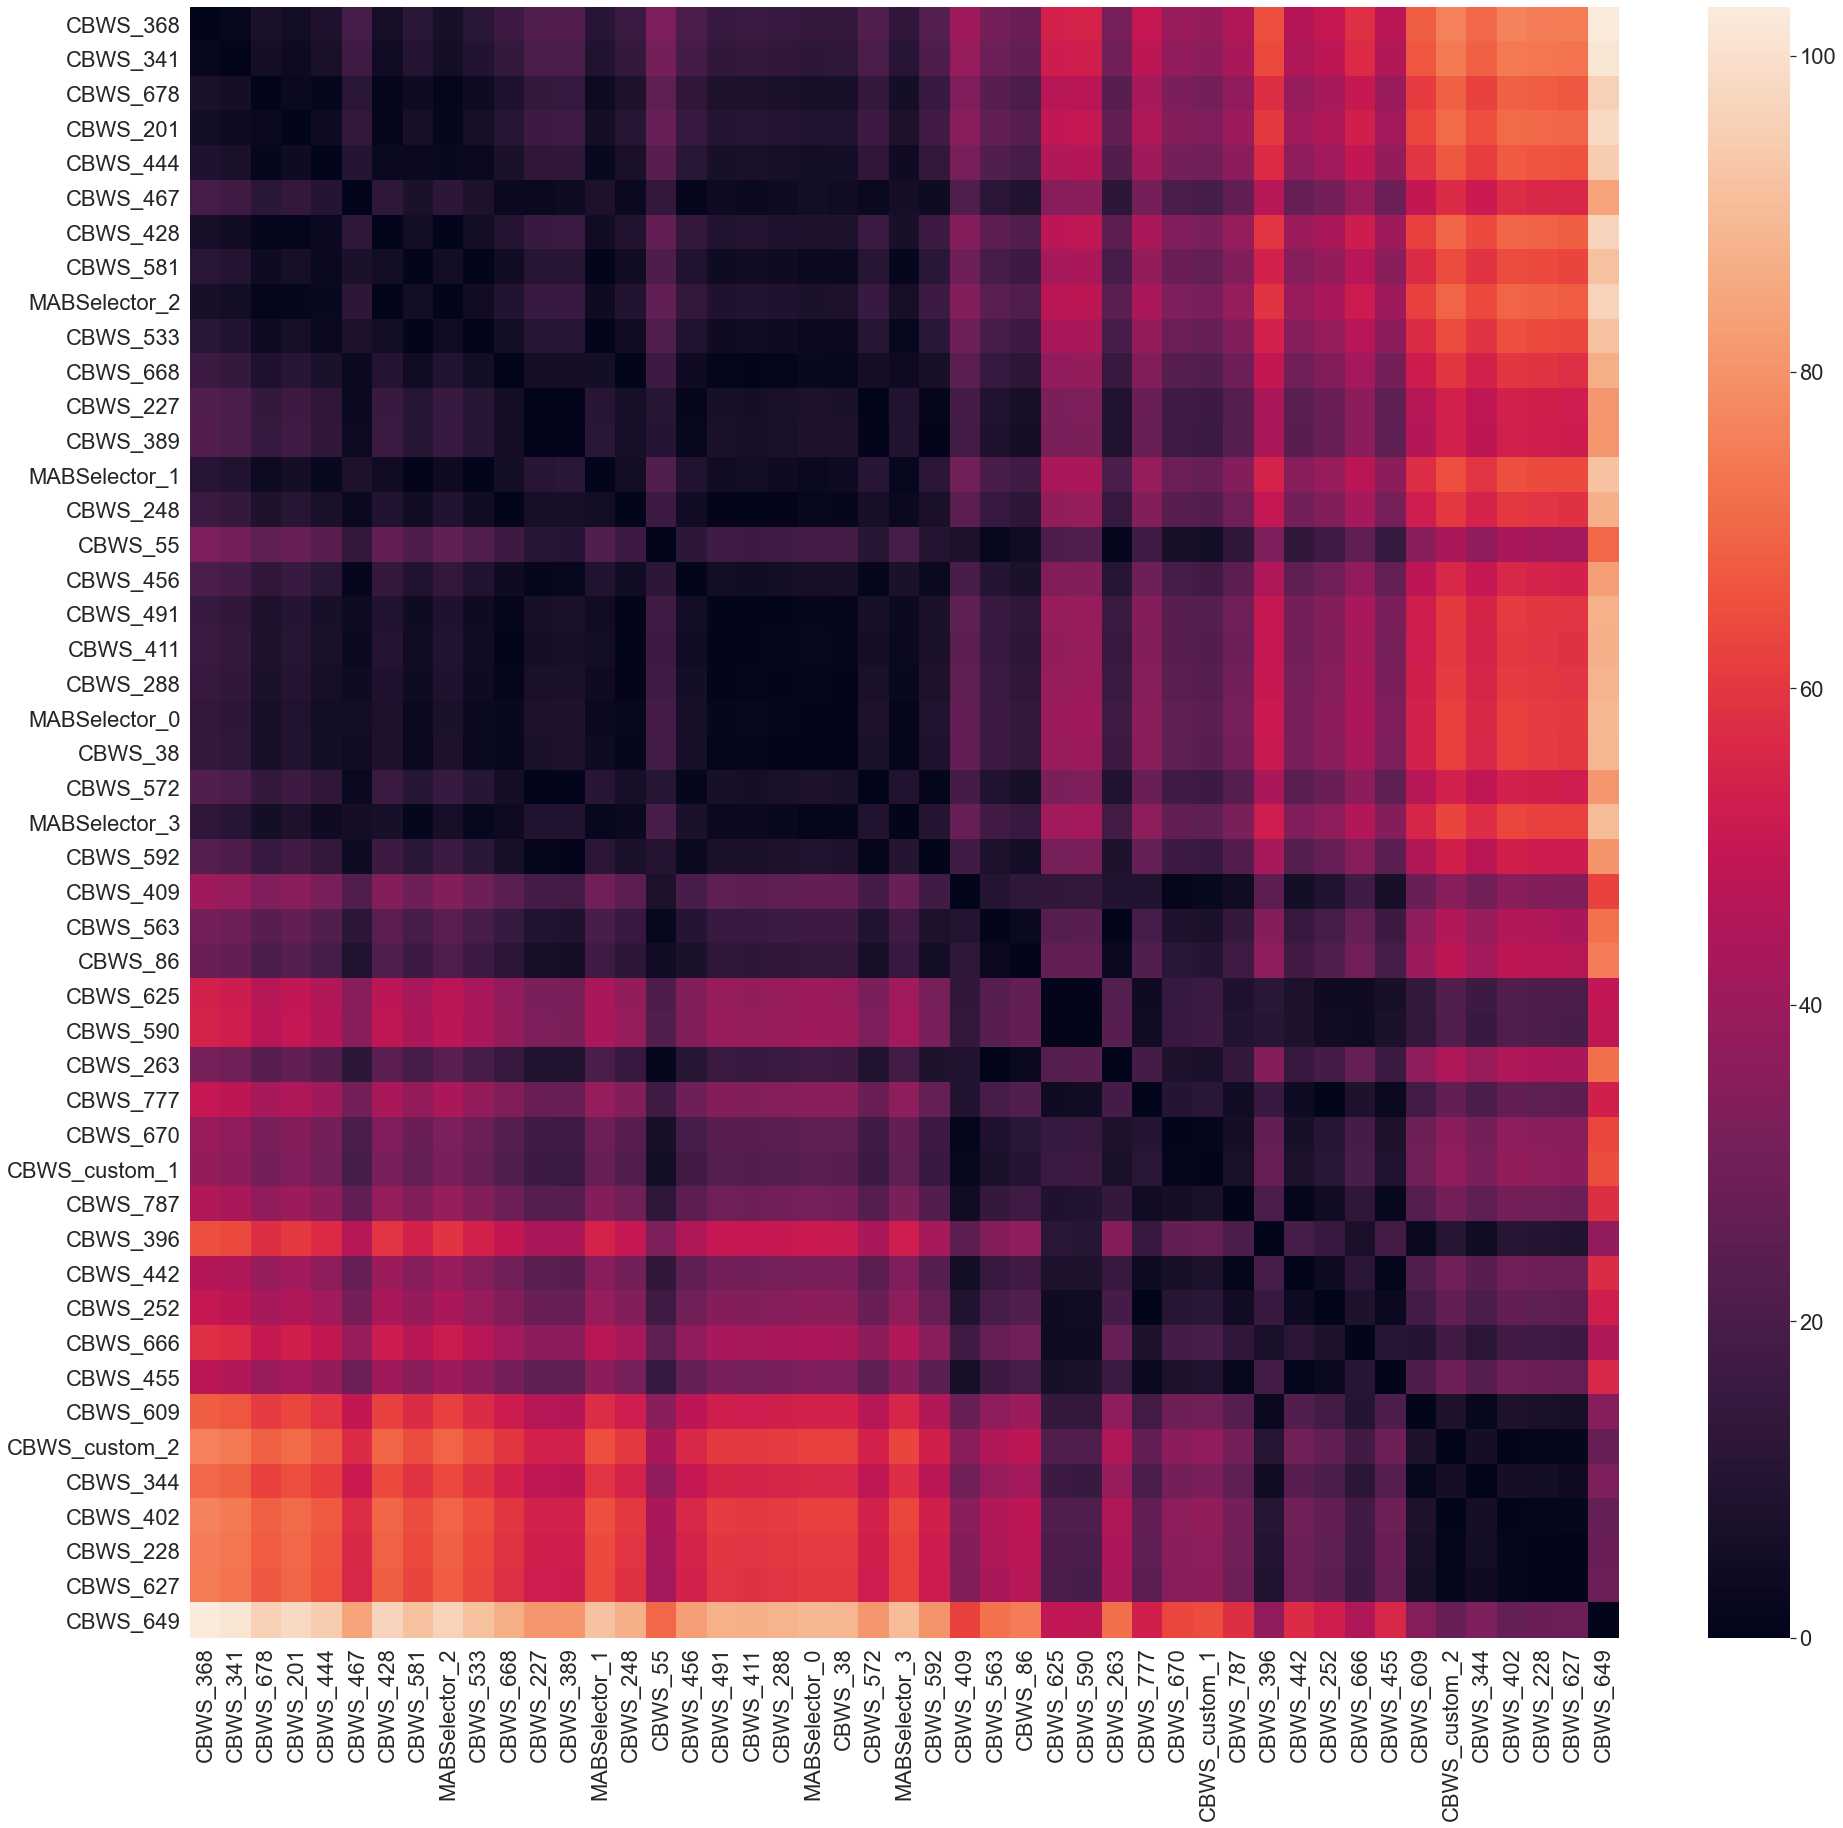

In [65]:
res = scmamp.contrastEstimationMatrix(data_df)
x_df = pd.DataFrame(res, columns=data_df.columns, index=data_df.columns)
plt.figure(figsize=(32, 30))
sns.heatmap(x_df.abs())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(<AxesSubplot:>, <matplotlib.colorbar.ColorbarBase at 0x258bb8b06a0>)

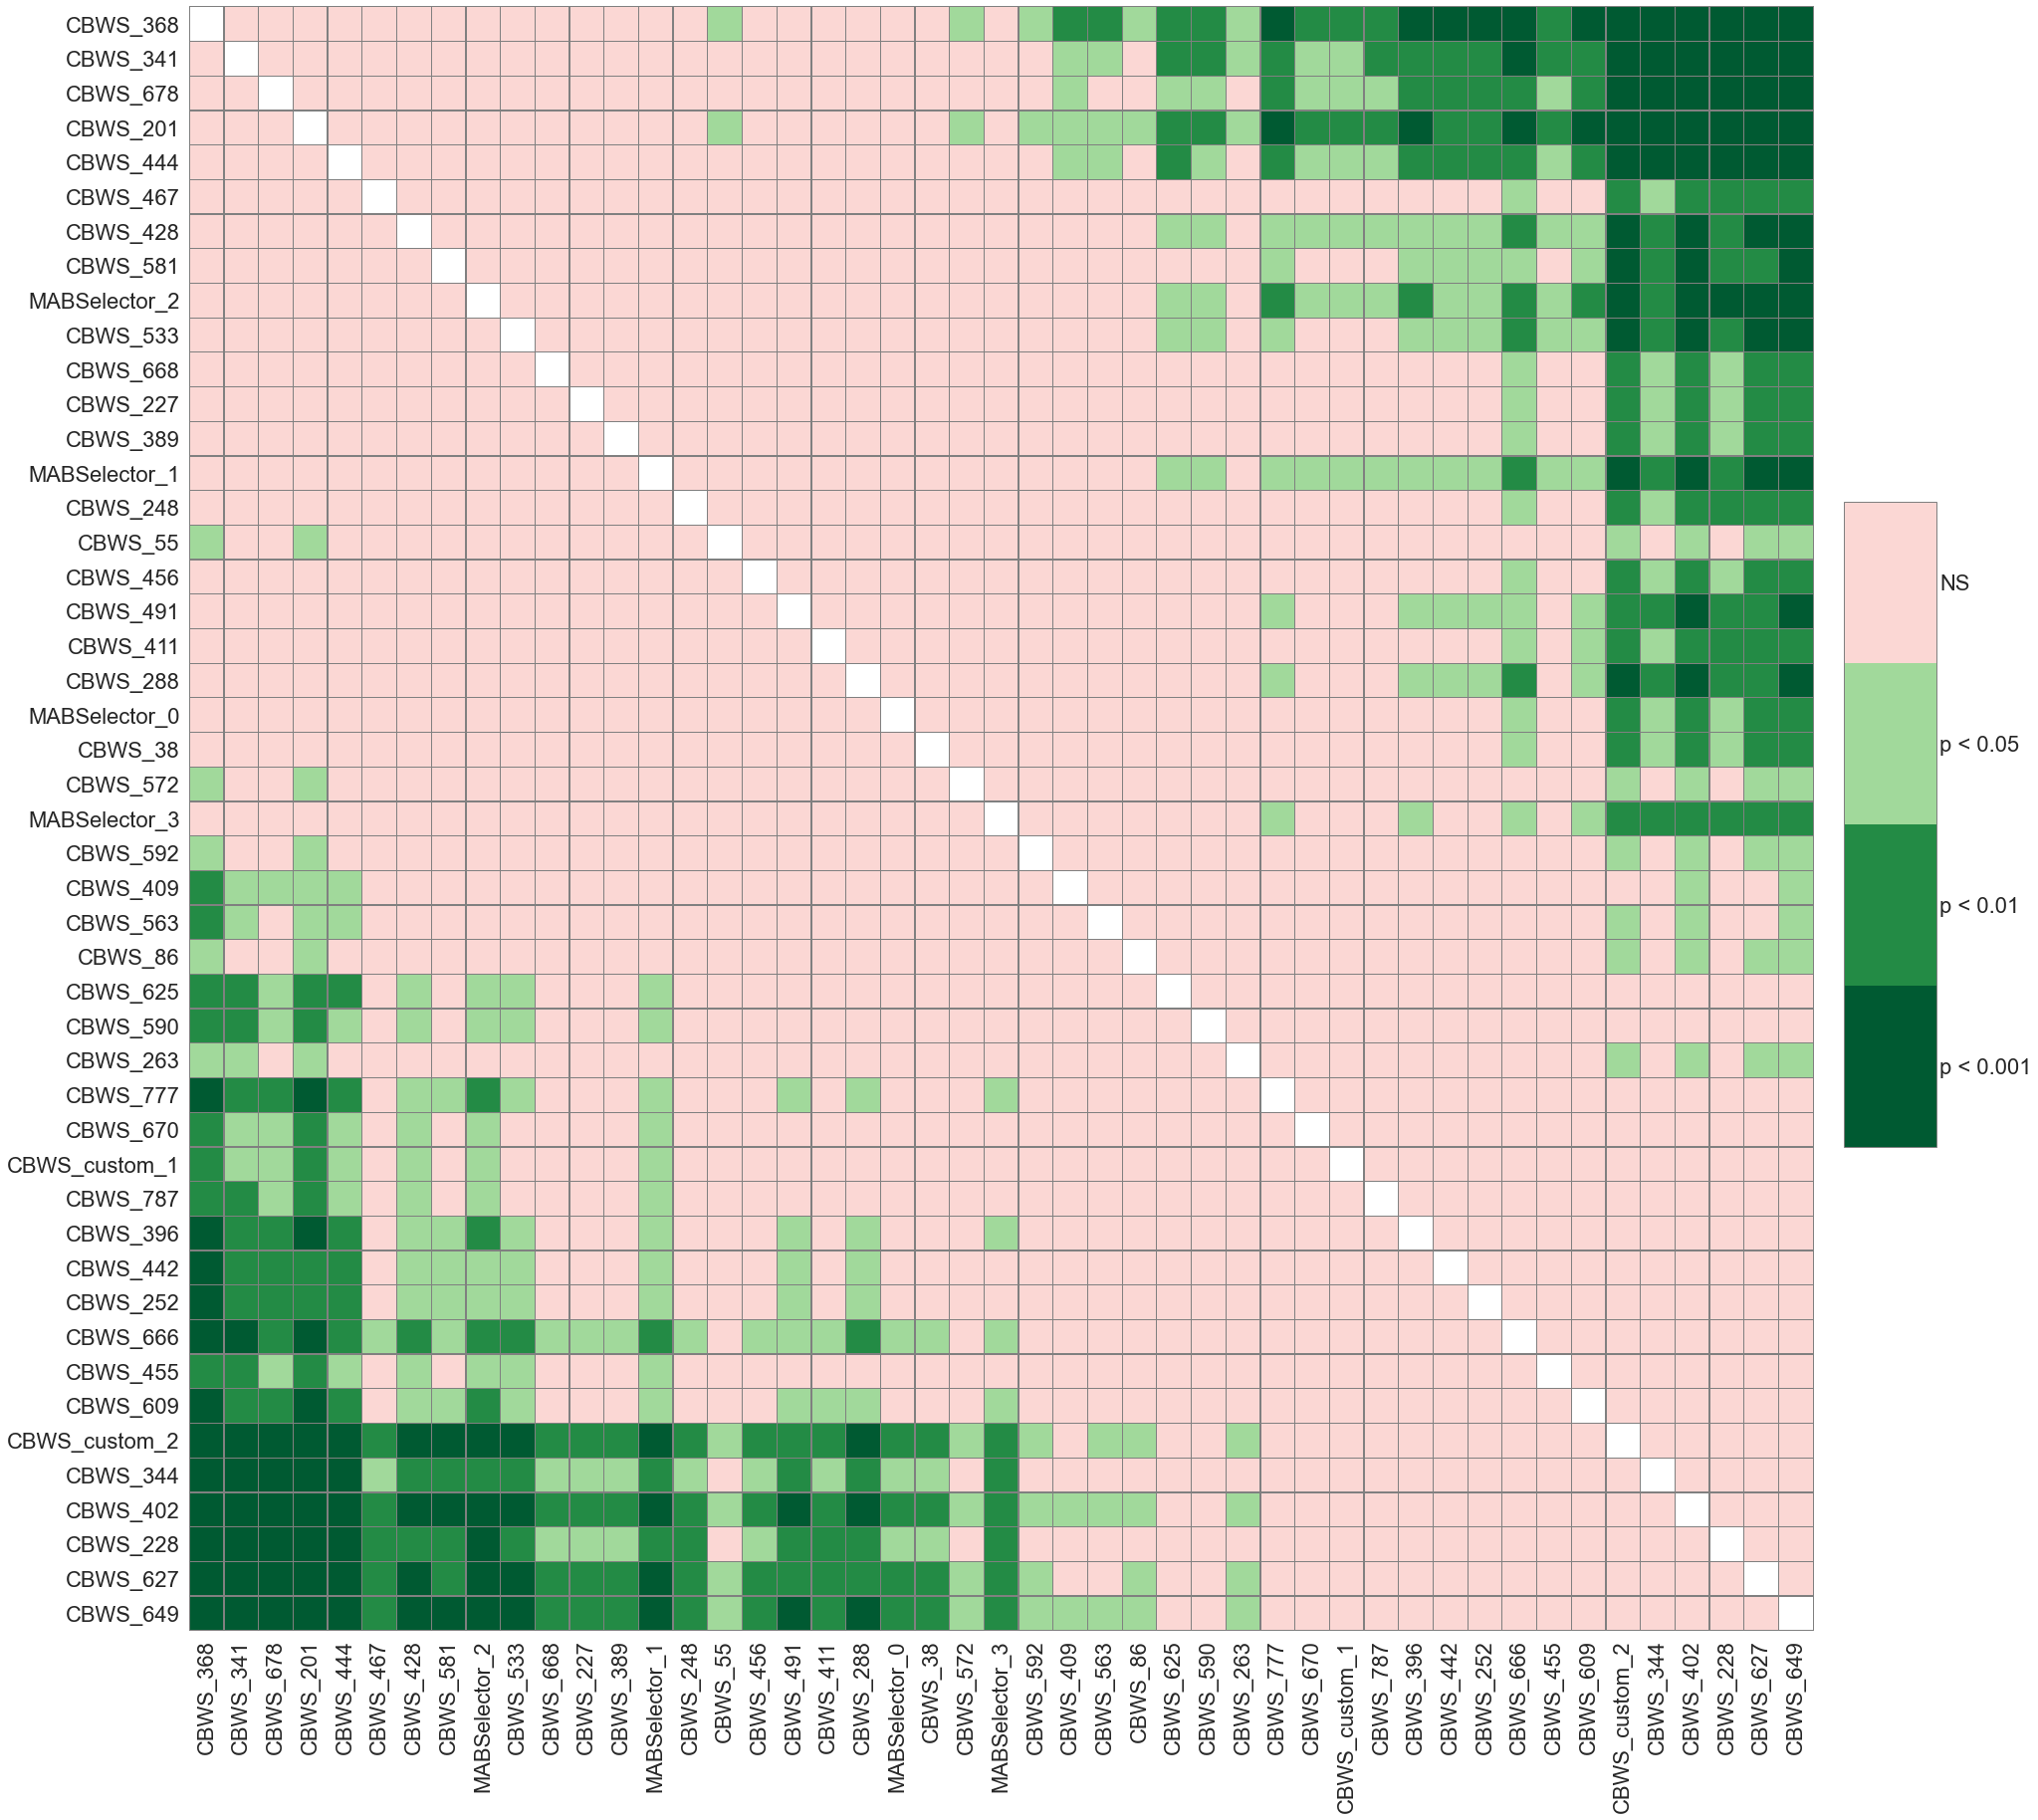

In [54]:
from stat_analysis import *
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper")
sns.set(font_scale=2)
%load_ext autoreload
%autoreload 2

import scikit_posthocs as sp
posthoc_pvals = sp.posthoc_conover_friedman(data_df)
plt.figure(figsize=(32, 30))
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 
                'square': True, 'cbar_ax_bbox': [0.88, 0.35, 0.04, 0.3]}
sp.sign_plot(posthoc_pvals, **heatmap_args)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(<AxesSubplot:>, <matplotlib.colorbar.ColorbarBase at 0x258c5b59160>)

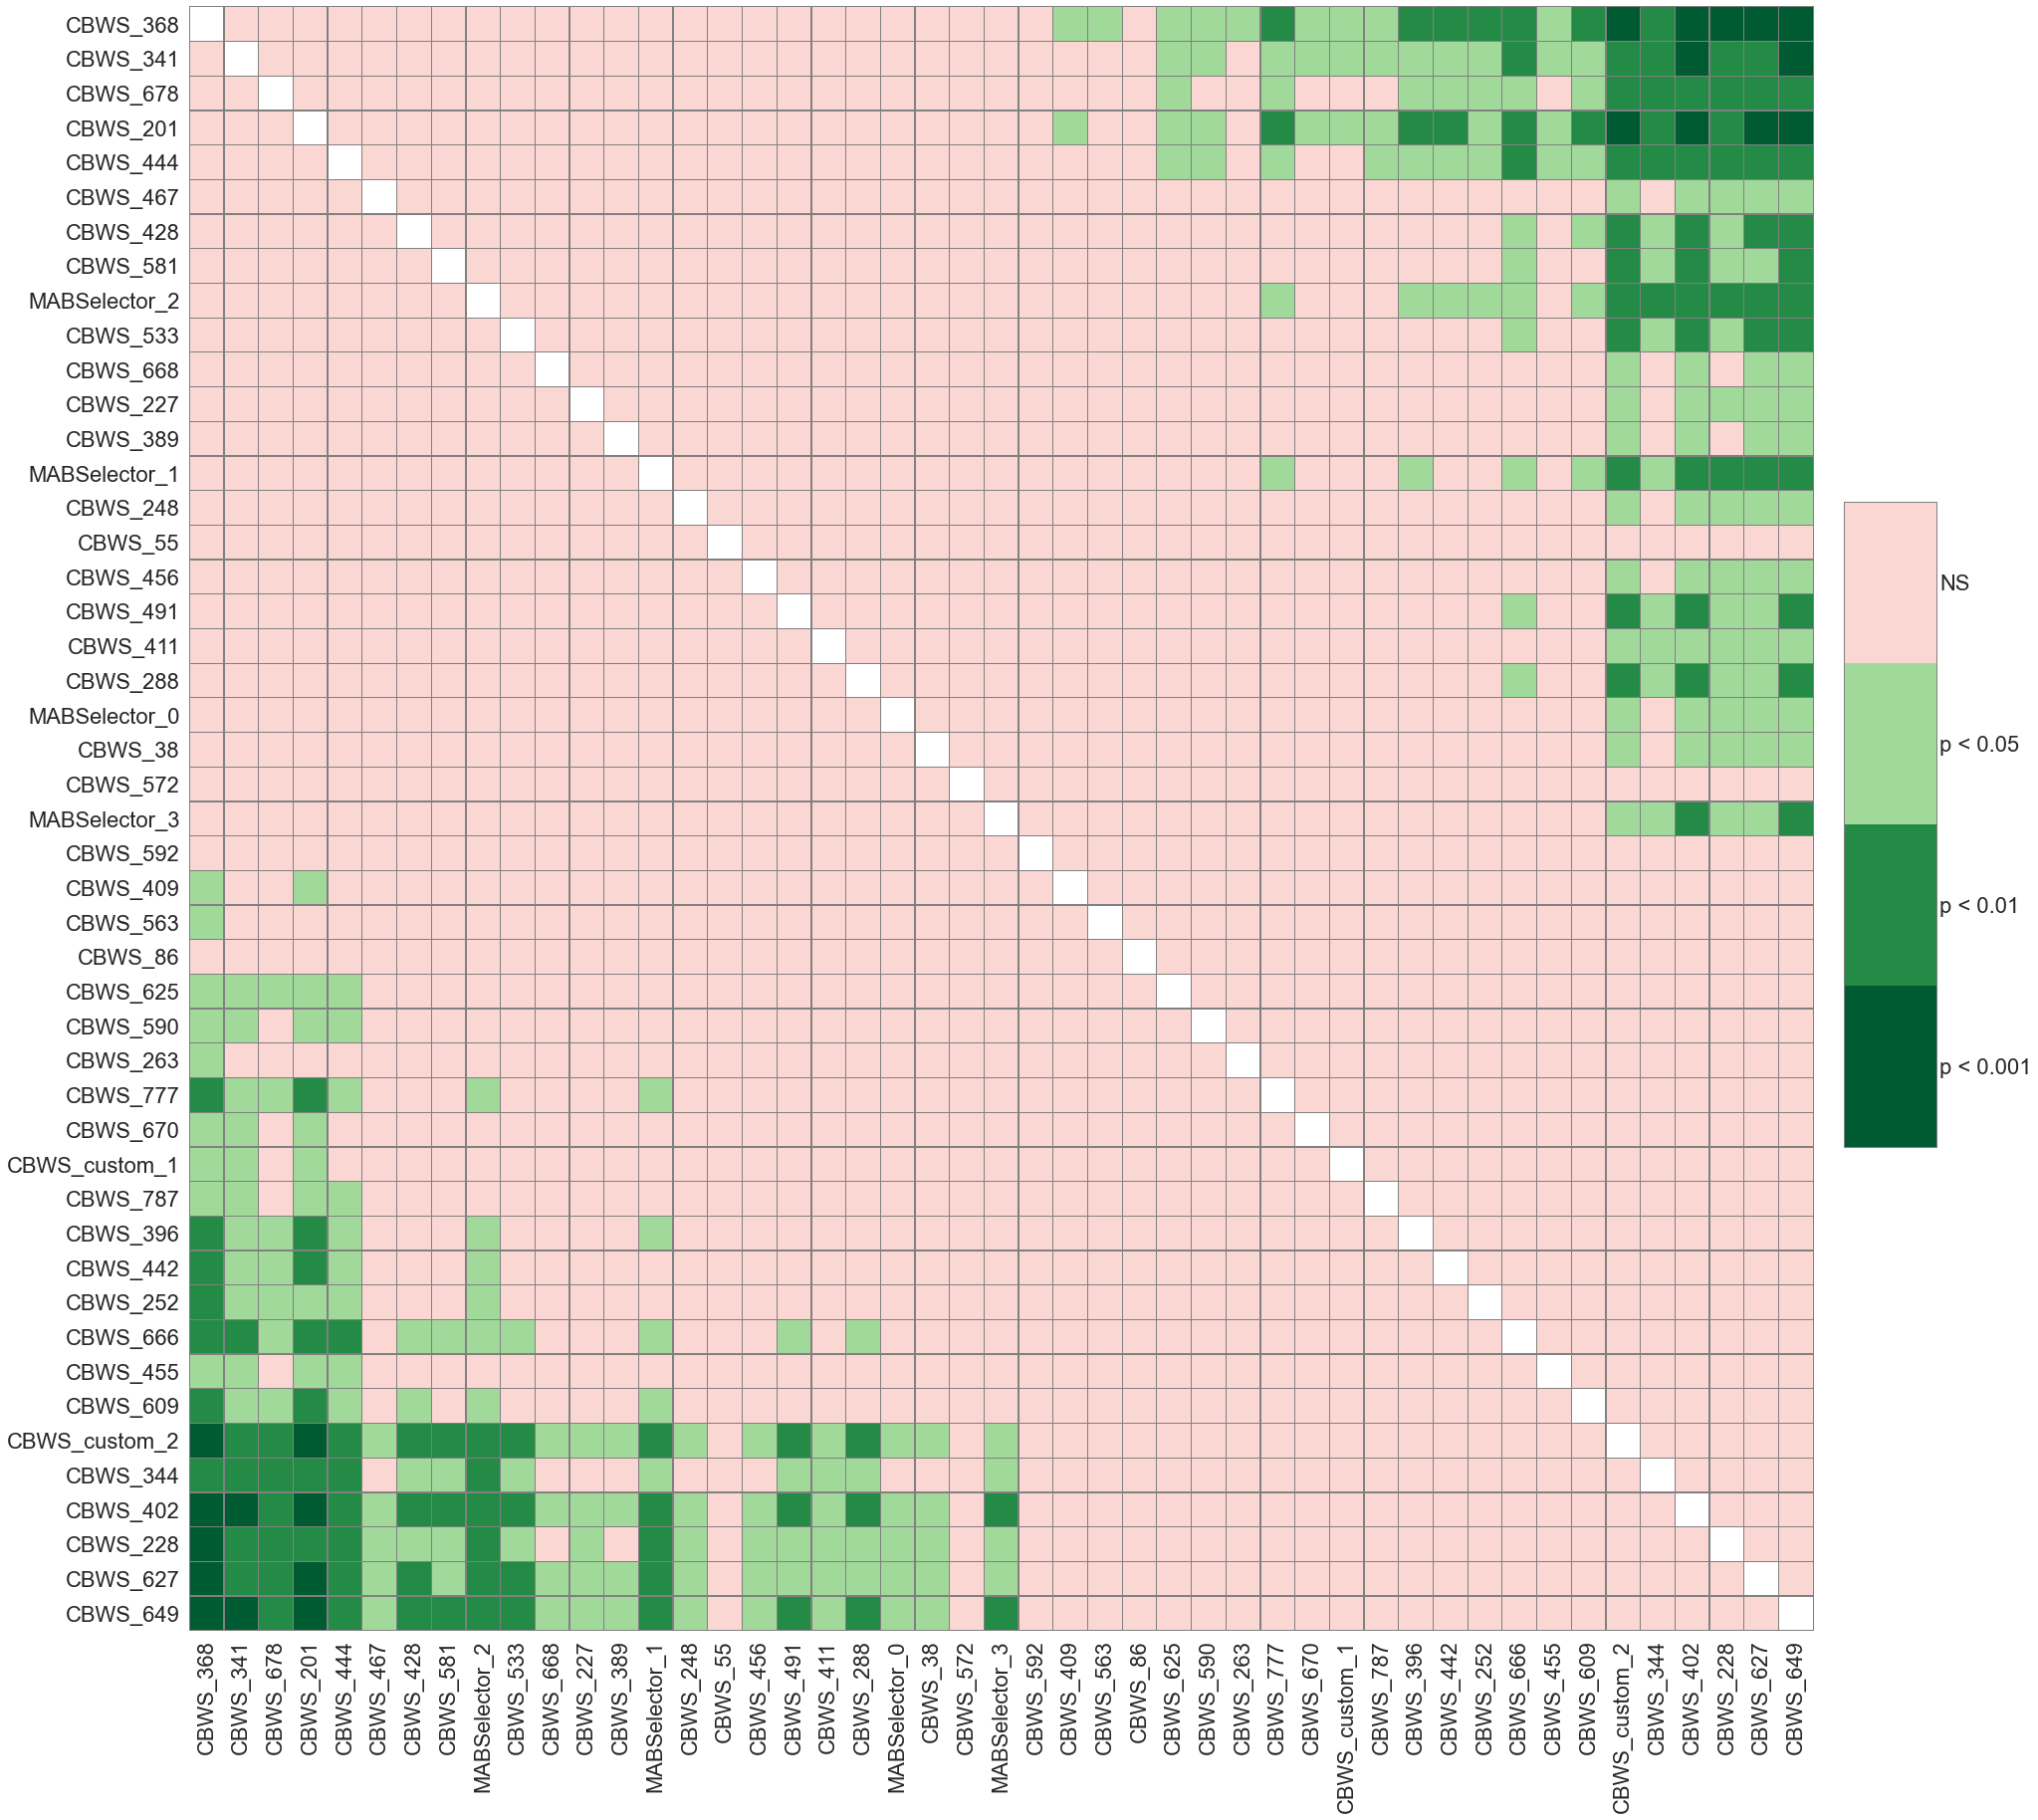

In [61]:
from stat_analysis import *
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper")
sns.set(font_scale=2)
%load_ext autoreload
%autoreload 2

import scikit_posthocs as sp
# perform nemenyi test
res = scmamp.postHocTest(data=data_df, test='friedman', correct='sfa', alpha=0.05)
raw_pval = res[1]
corr_pval = res[2]
posthoc_finner = pd.DataFrame(corr_pval, columns=data_df.columns, index=data_df.columns)

plt.figure(figsize=(32, 30))
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 
                'square': True, 'cbar_ax_bbox': [0.88, 0.35, 0.04, 0.3]}
sp.sign_plot(posthoc_finner, **heatmap_args)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<AxesSubplot:>

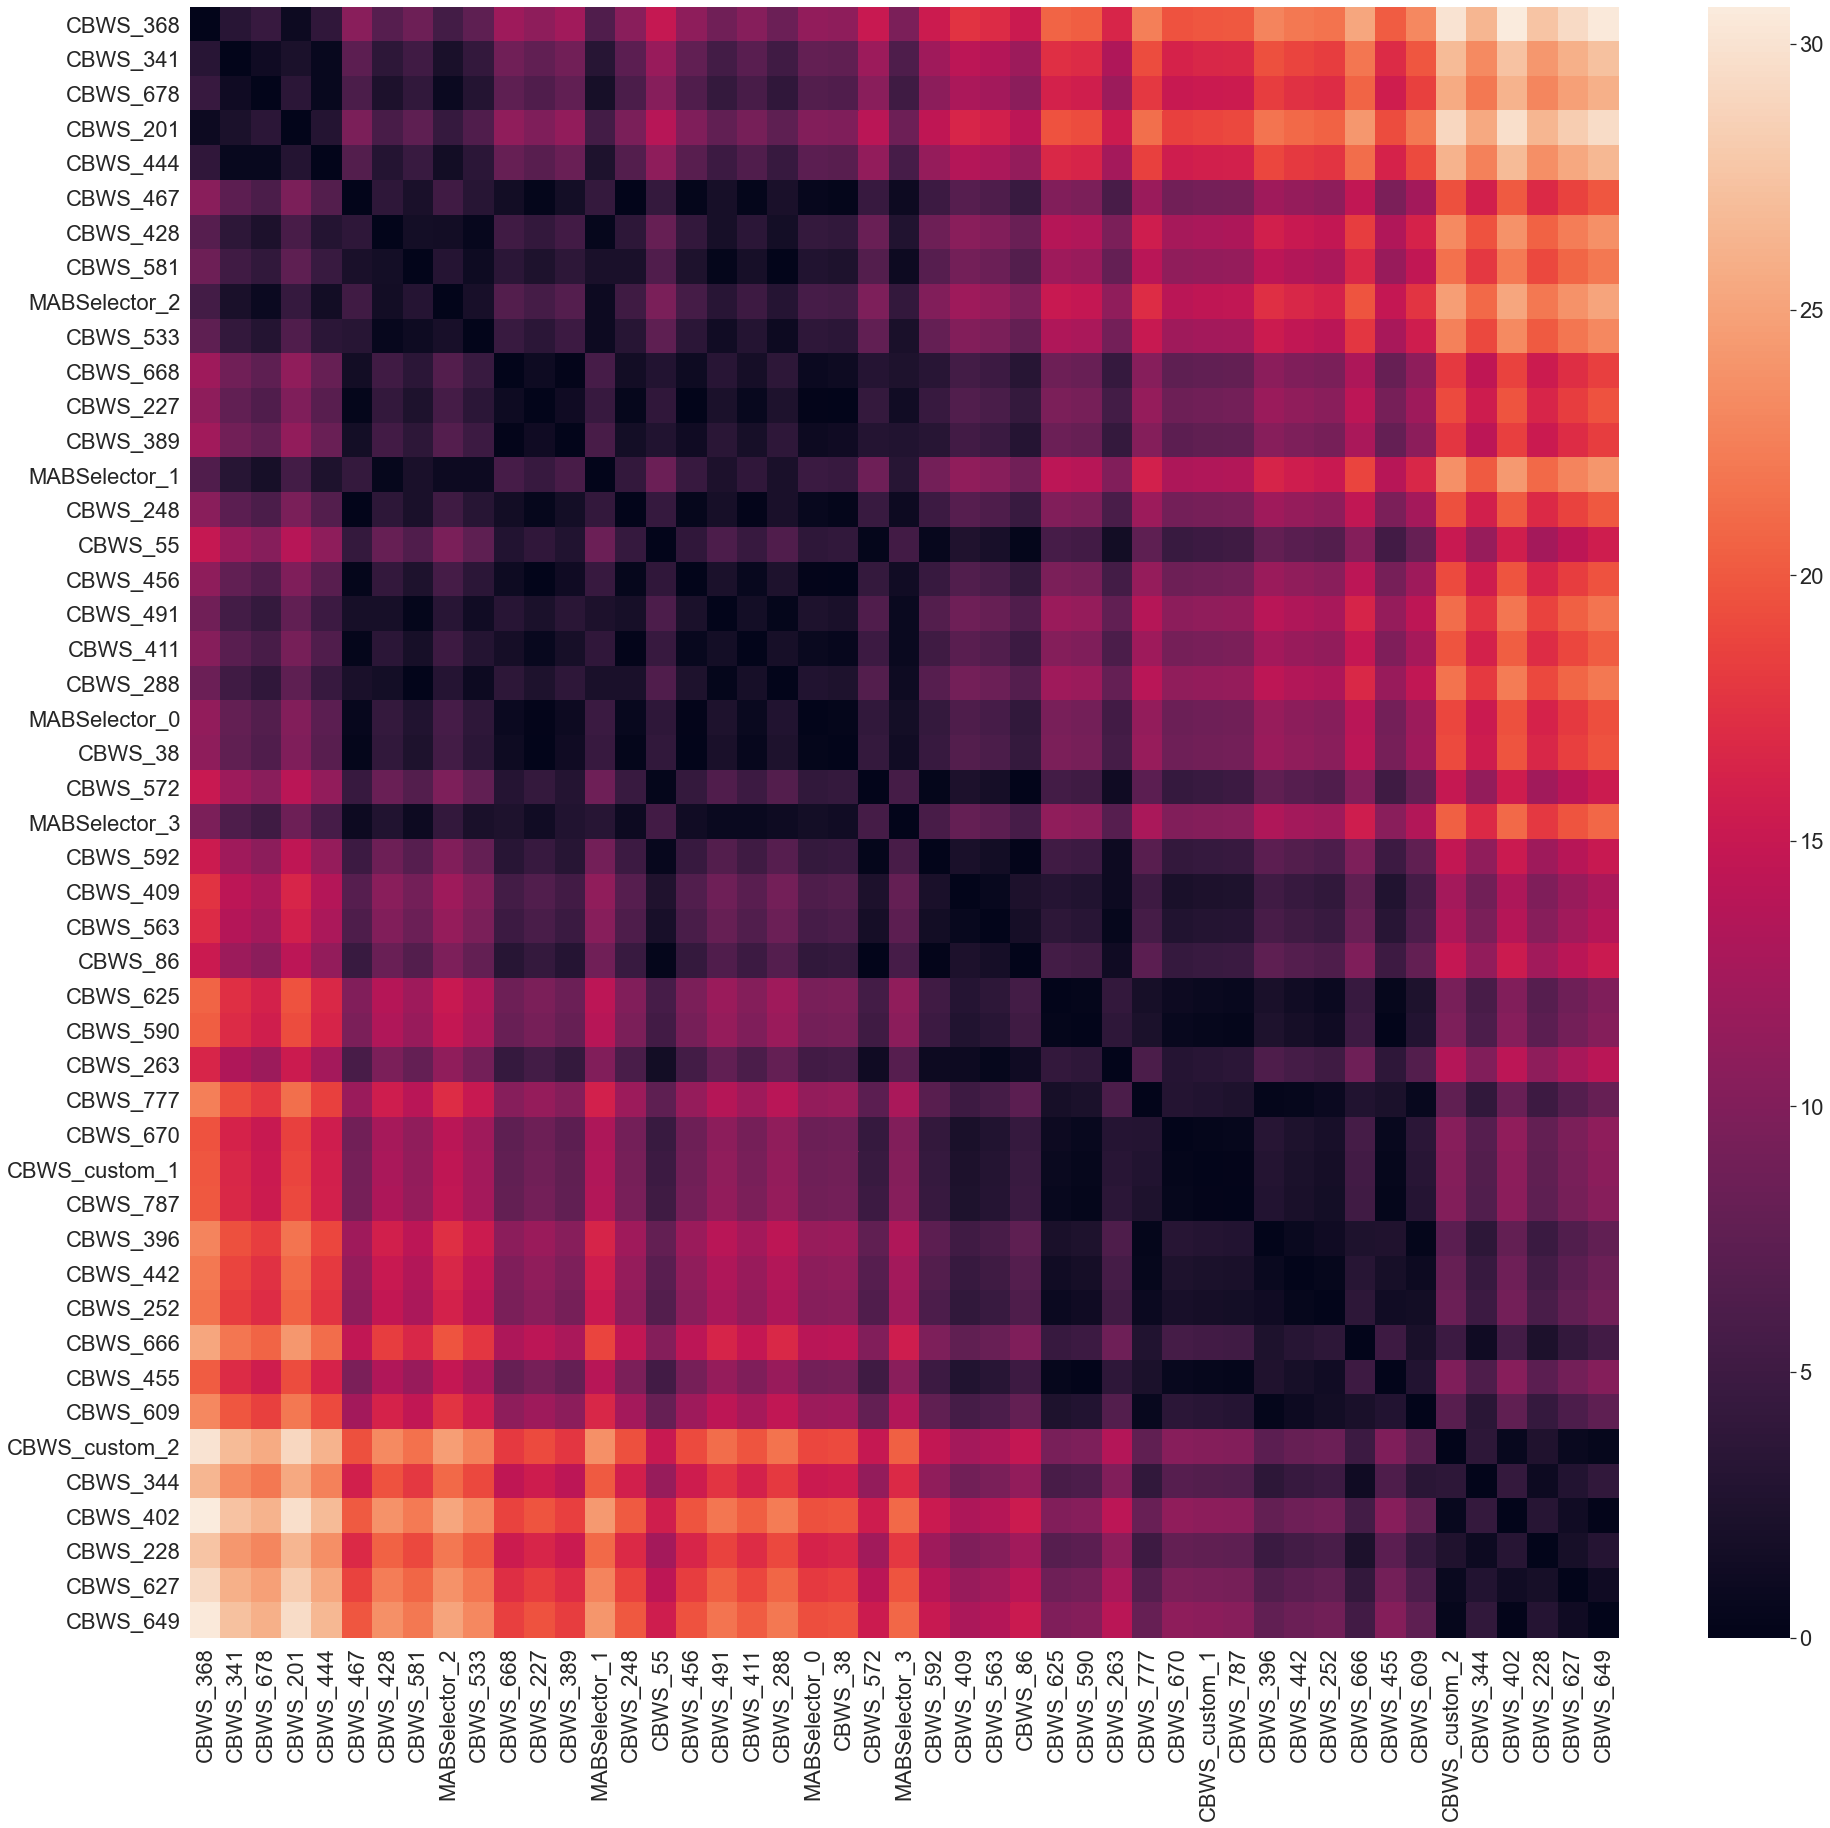

In [27]:
from stat_analysis import *
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper")
sns.set(font_scale=2)
%load_ext autoreload
%autoreload 2

plt.figure(figsize=(32, 30))
sns.heatmap(nem_diff_df.abs())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<AxesSubplot:>

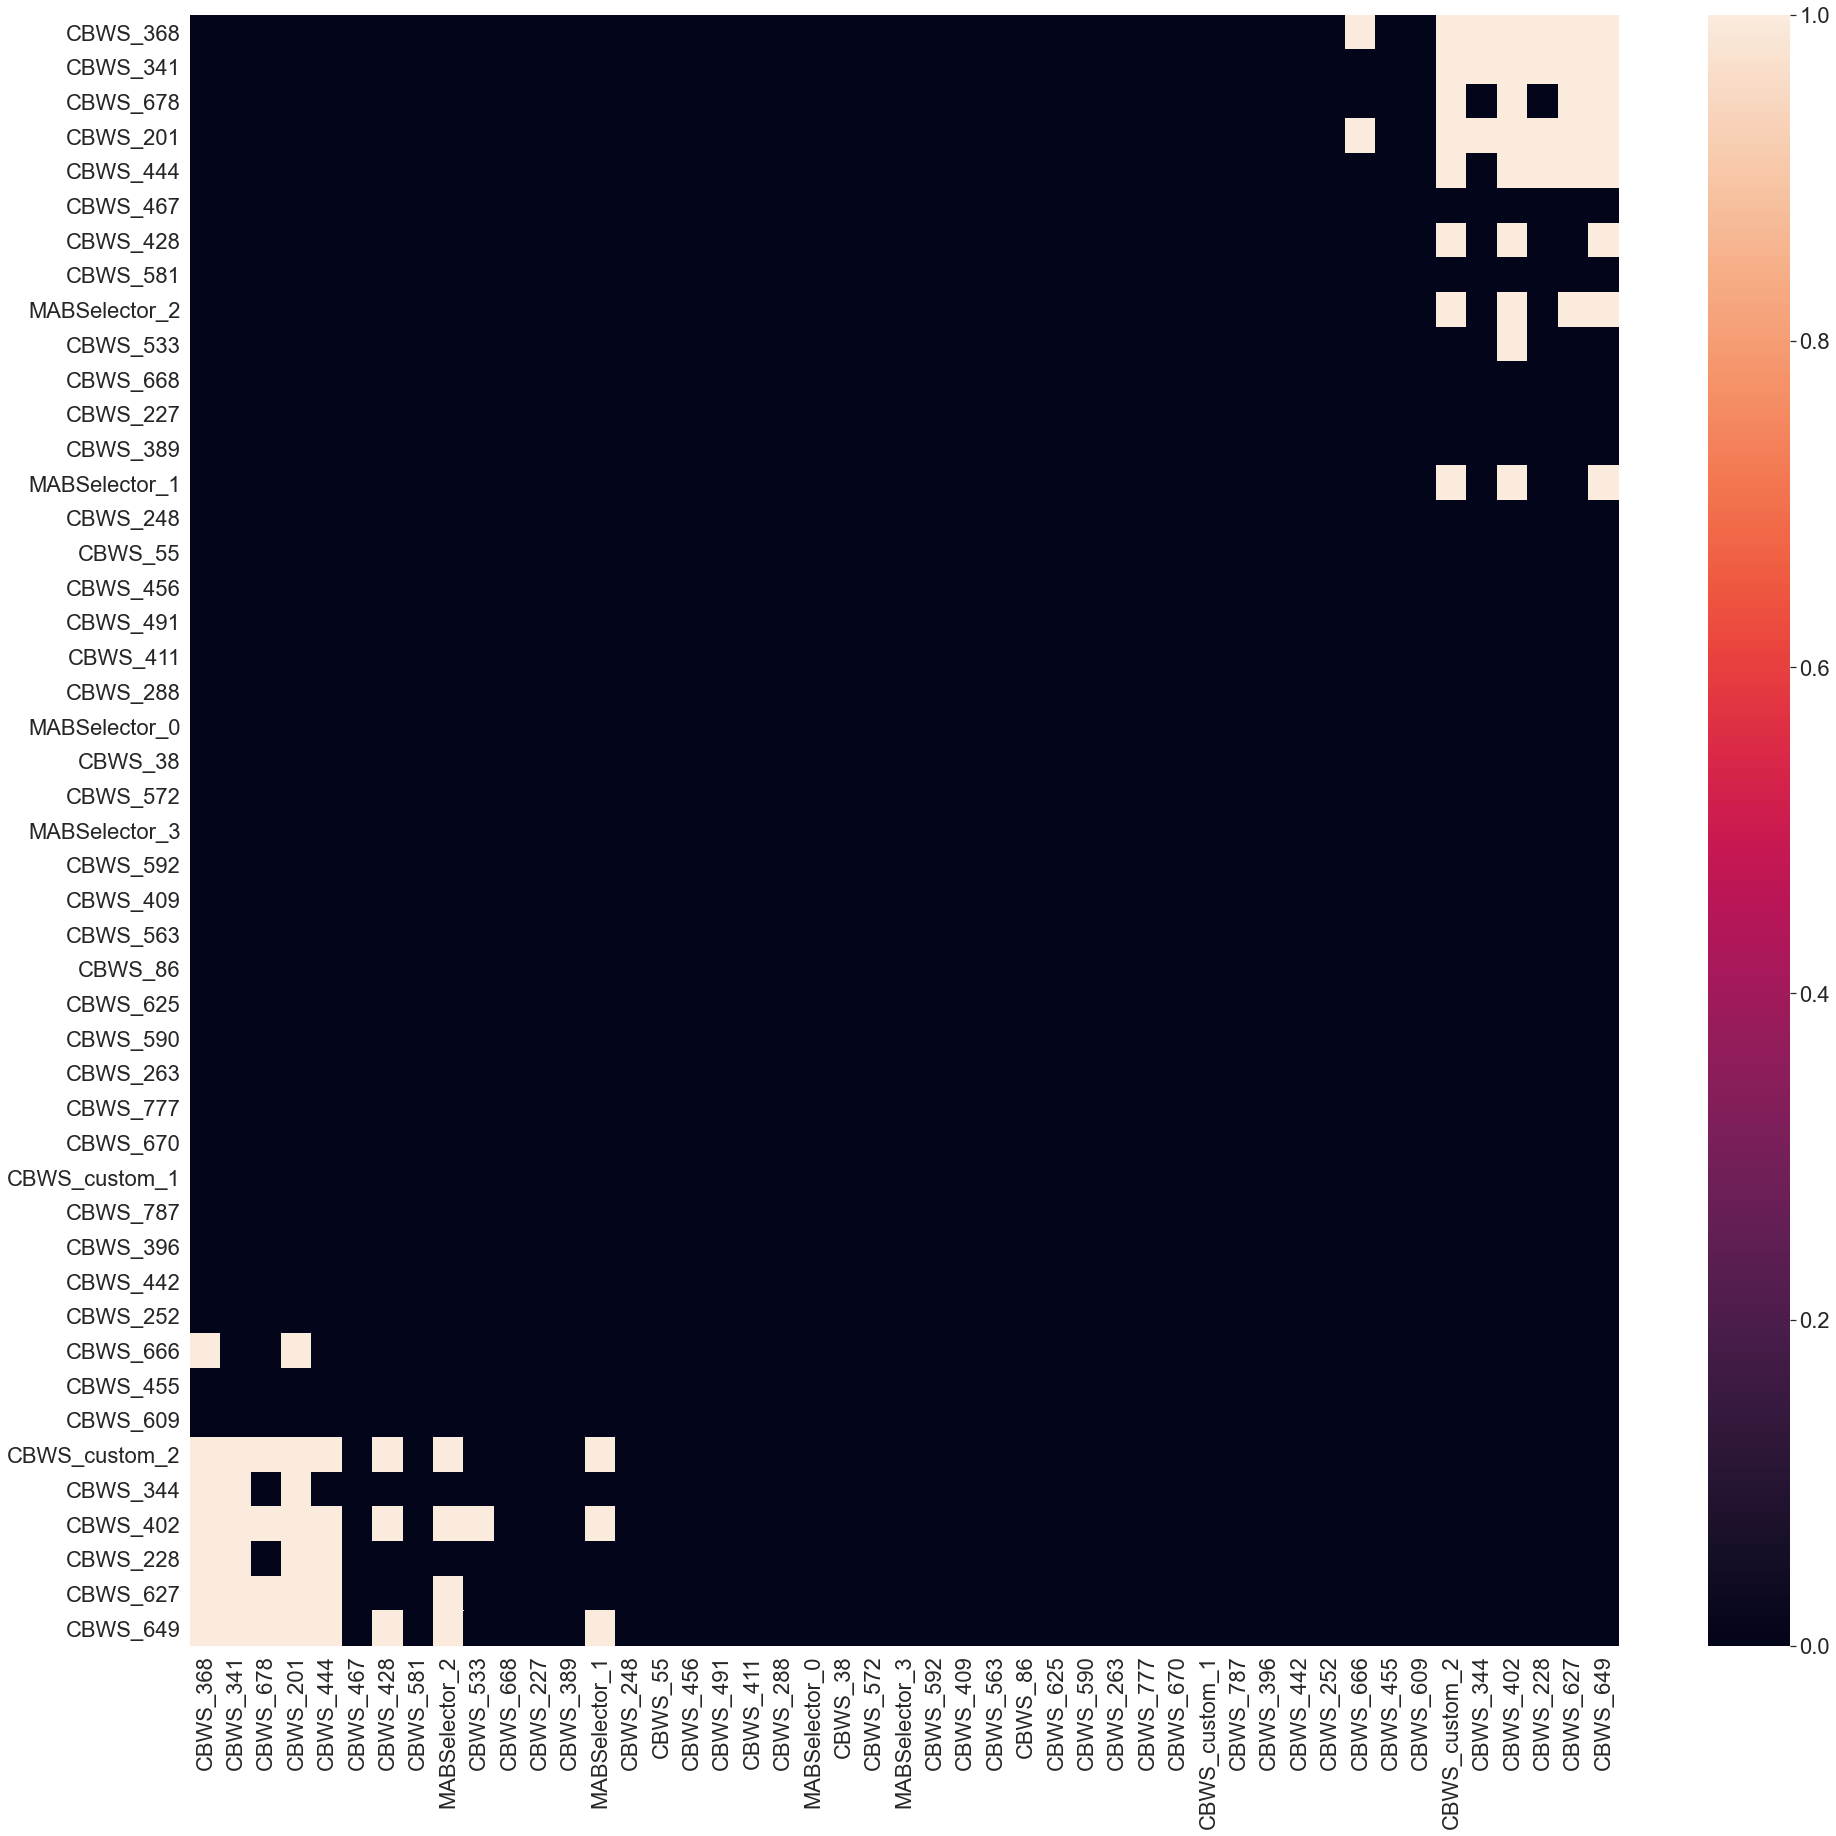

In [28]:
from stat_analysis import *
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper")
sns.set(font_scale=2)
%load_ext autoreload
%autoreload 2

plt.figure(figsize=(32, 30))
sns.heatmap(sig_diff_df)